# 🔍 Tutorial: Análise de Sentimentos em Português com BERT

Neste tutorial, vamos aprender como usar o modelo BERT para prever o **sentimento (positivo ou negativo)** de comentários em português no IMDB.

Utilizaremos o modelo **BERT pré-treinado da Hugging Face** (`neuralmind/bert-base-portuguese-cased`) e faremos o fine-tuning com PyTorch.

## 📌 1. O que é o BERT?

O **BERT** (Bidirectional Encoder Representations from Transformers) é um modelo baseado em Transformers, ideal para tarefas de NLP como classificação de texto, análise de sentimentos, entre outros.

Neste caso, usamos o **encoder** do BERT para classificar frases como **positivas** ou **negativas**.



In [38]:
%pip install torch torchvision torchaudio \
    transformers datasets scikit-learn pandas plotly \
    tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 27.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --upgrade jupyter ipywidgets
%jupyter nbextension enable --py widgetsnbextension # removed !pip on the recommendation of a comment.

import time
from tqdm.notebook import tqdm
for i in tqdm(range(10)):
    time.sleep(0.1)

## 📂 2. Carregando os Dados

Vamos usar um dataset com resenhas do IMDB traduzidas para português.

In [39]:
import pandas as pd

# Carrega o dataset
data = pd.read_csv("dataset/imdb-reviews-pt-br.csv", index_col=0)
data.head()

,text_en,text_pt,sentiment
id,,,
1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


### 📊 Estrutura do Dataset

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49459 entries, 1 to 49460
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_en    49459 non-null  object
 1   text_pt    49459 non-null  object
 2   sentiment  49459 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


Temos 3 colunas:

* `text_en`: texto original em inglês
* `text_pt`: texto traduzido para português
* `sentiment`: rótulo de sentimento (`pos` ou `neg`)

## 📈 3. Explorando a Distribuição de Sentimentos

<Axes: ylabel='count'>

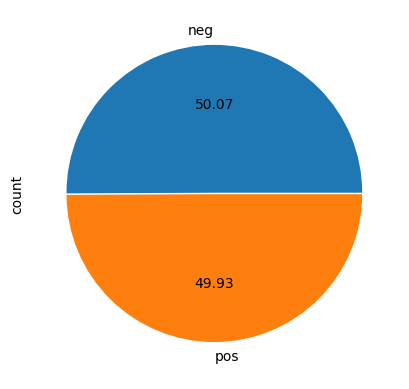

In [41]:
data["sentiment"].value_counts().plot.pie(autopct="%.2f", explode=[0.01, 0])

O dataset está **balanceado**, então podemos usar **acurácia** como métrica principal.

## 🧪 4. Dividindo os Dados

Vamos criar conjuntos de treino, validação (dev) e teste na proporção 90/5/5.

In [42]:
from sklearn.model_selection import train_test_split

test_dev_size = int(0.05 * len(data))
train_dev, test = train_test_split(
    data, test_size=test_dev_size, stratify=data["sentiment"], random_state=42
)
train, dev = train_test_split(
    train_dev, test_size=test_dev_size, stratify=train_dev["sentiment"], random_state=42
)

## 🔁 5. Preparando o Dataset para o BERT

Criamos uma classe para tokenizar e estruturar os dados conforme esperado pelo BERT.

In [43]:
from torch.utils.data import Dataset


class ImdbPt(Dataset):
    def __init__(self, tokenizer, X, y):
        tokenized = tokenizer(list(X), truncation=True, max_length=512)
        self.samples = [
            {**{k: tokenized[k][i] for k in tokenized}, "labels": y.iloc[i]}
            for i in range(len(X))
        ]

    def __getitem__(self, i):
        return self.samples[i]

    def __len__(self):
        return len(self.samples)

## 🧼 6. Tokenizando e Criando Loaders

In [44]:
from transformers import BertTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader

tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

train_dataset = ImdbPt(
    tokenizer, train["text_pt"], (train["sentiment"] == "pos").astype(int)
)
dev_dataset = ImdbPt(tokenizer, dev["text_pt"], (dev["sentiment"] == "pos").astype(int))
test_dataset = ImdbPt(
    tokenizer, test["text_pt"], (test["sentiment"] == "pos").astype(int)
)

collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collator)
dev_loader = DataLoader(dev_dataset, batch_size=16, collate_fn=collator)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collator)

Exception ignored in: <function tqdm.__del__ at 0x32168f100>
Traceback (most recent call last):
  File "/Users/gsampaio/redhat/ai/chatbot_sentiment_analysis/.env/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/gsampaio/redhat/ai/chatbot_sentiment_analysis/.env/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


## ⚙️ 7. Carregando o Modelo e Configurando o Treinamento

In [45]:
import torch
from transformers import BertForSequenceClassification
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased"
)
model.to(device)

# Congelando o BERT no início
for param in model.base_model.parameters():
    param.requires_grad = False

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9997)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 🧠 8. Funções Auxiliares

In [46]:
def send_inputs_to_device(inputs, device):
    return {k: v.to(device) for k, v in inputs.items()}


def evaluate(model, loader, device):
    model.eval()
    tp = tn = fp = fn = 0
    losses = []

    with torch.no_grad():
        for batch in loader:
            batch = send_inputs_to_device(batch, device)
            loss, scores = model(**batch)[:2]
            losses.append(loss.item())
            pred = scores.argmax(dim=1)
            labels = batch["labels"]

            tp += ((pred == 1) & (labels == 1)).sum().item()
            tn += ((pred == 0) & (labels == 0)).sum().item()
            fp += ((pred == 1) & (labels == 0)).sum().item()
            fn += ((pred == 0) & (labels == 1)).sum().item()

    acc = (tp + tn) / (tp + tn + fp + fn)
    print(
        f"Dev loss: {sum(losses)/len(losses):.2f}; Acc: {acc:.2f}; tp: {tp}; tn: {tn}; fp: {fp}; fn: {fn}"
    )
    model.train()

## 🚀 9. Treinando o Modelo

In [47]:
from tqdm.notebook import tqdm

loss_acc = 0
alpha = 0.95
for epoch in tqdm(range(1)):
    for step, batch in tqdm(
        enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}"
    ):
        if epoch * len(train_loader) + step == 800:
            for param in model.base_model.parameters():
                param.requires_grad = True

        batch = send_inputs_to_device(batch, device)
        optimizer.zero_grad()
        loss, _ = model(**batch)[:2]
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Loss moving average
        loss_acc = (
            loss.item() if step == 0 else loss_acc * alpha + loss.item() * (1 - alpha)
        )

        if step % 200 == 0:
            evaluate(model, dev_loader, device)

    model.save_pretrained(f"/models/working/checkpoints/epoch{epoch}")

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

## 📉 10. Curva ROC e Threshold Ideal

In [ ]:
from sklearn import metrics
import torch.nn.functional as F
import plotly.express as px

model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in dev_loader:
        batch = send_inputs_to_device(batch, device)
        _, scores = model(**batch)[:2]
        probs = F.softmax(scores, dim=1)[:, 1]
        preds.append(probs.cpu())
        true_labels.append(batch["labels"].cpu())

preds = torch.cat(preds).numpy()
true_labels = torch.cat(true_labels).numpy()

fpr, tpr, thresholds = metrics.roc_curve(true_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

px.scatter(x=fpr, y=tpr, color=thresholds, title="Curva ROC").show()

accuracies = [metrics.accuracy_score(preds > th, true_labels) for th in thresholds]
px.scatter(x=thresholds, y=accuracies, title="Acurácia por Threshold").show()

## 🧾 11. Avaliação Final no Test Set

In [ ]:
with torch.no_grad():
    model.eval()
    preds, true_labels = [], []
    for batch in test_loader:
        batch = send_inputs_to_device(batch, device)
        _, scores = model(**batch)[:2]
        probs = F.softmax(scores, dim=1)[:, 1]
        preds.append(probs.cpu())
        true_labels.append(batch["labels"].cpu())

preds = torch.cat(preds).numpy()
true_labels = torch.cat(true_labels).numpy()

# Usando o melhor threshold encontrado
final_acc = metrics.accuracy_score(preds > 0.67, true_labels)
print(f"Acurácia no Teste: {final_acc:.4f}")

## ✅ Conclusão

Neste tutorial, mostramos como aplicar o BERT para análise de sentimentos em português:

* Usamos o modelo `neuralmind/bert-base-portuguese-cased`
* Processamos e tokenizamos os dados
* Treinamos o modelo com congelamento inicial
* Avaliamos e otimizamos o threshold via curva ROC

Essa abordagem pode ser adaptada para outras tarefas de NLP em português. Experimente com datasets diferentes!